# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [346]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [ ]:
df.head()

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [66]:
df_cleaned = df.drop(['day_of_week', 'pdays', 'month', 'previous', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'nr.employed','euribor3m'], axis=1)
df_cleaned

,age,job,marital,education,default,housing,loan,contact,duration,campaign,emp.var.rate,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,261,1,1.1,no
1,57,services,married,high.school,unknown,no,no,telephone,149,1,1.1,no
2,37,services,married,high.school,no,yes,no,telephone,226,1,1.1,no
3,40,admin.,married,basic.6y,no,no,no,telephone,151,1,1.1,no
4,56,services,married,high.school,no,no,yes,telephone,307,1,1.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,334,1,-1.1,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,383,1,-1.1,no
41185,56,retired,married,university.degree,no,yes,no,cellular,189,2,-1.1,no
41186,44,technician,married,professional.course,no,no,no,cellular,442,1,-1.1,yes


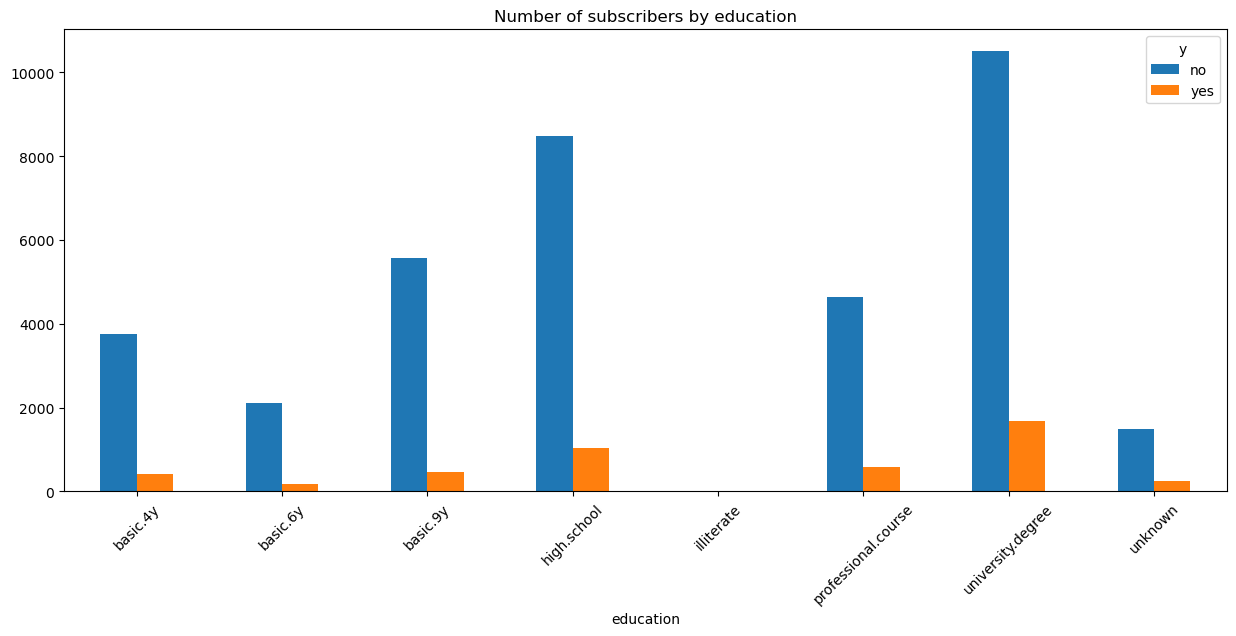

In [124]:
grouped=df_cleaned.groupby(['education','y']).size()
unstacked = grouped.unstack()

# Plot the data
unstacked.plot(kind='bar',figsize=(15, 6))

plt.title('Number of subscribers by education')
plt.xticks(rotation=45, ha='center')

plt.show()


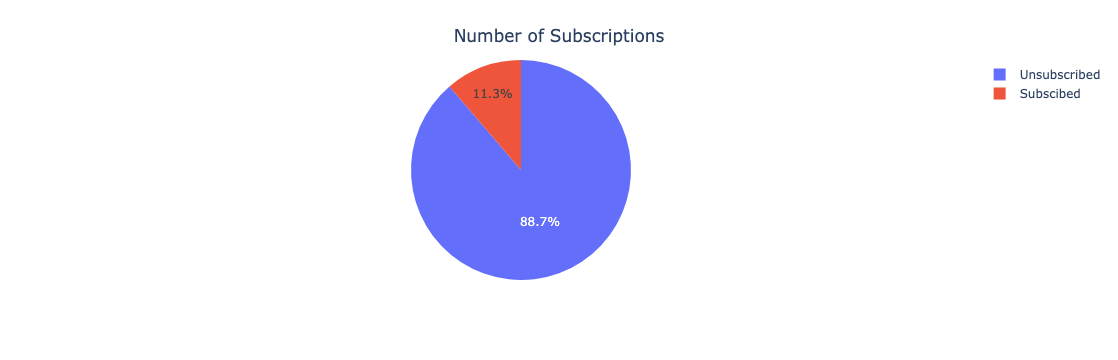

In [350]:
total=len(df_cleaned)
subscribed=len(df_cleaned[df_cleaned['y']=='yes'])
# Create pie chart based on client subscription
pie_data = {'labels': ['Subscibed', 'Unsubscribed'], 
            'values': [subscribed,(total-subscribed)]}

fig = px.pie(pie_data, values='values', names='labels')
fig.update_layout(
    title={
        'text': 'Number of Subscriptions',
        'x': 0.5,  # Set the x position to the center
        'xanchor': 'center',  # Anchor the title to the center
        'yanchor': 'top'  # Anchor the title to the top
    }
)

fig.show()

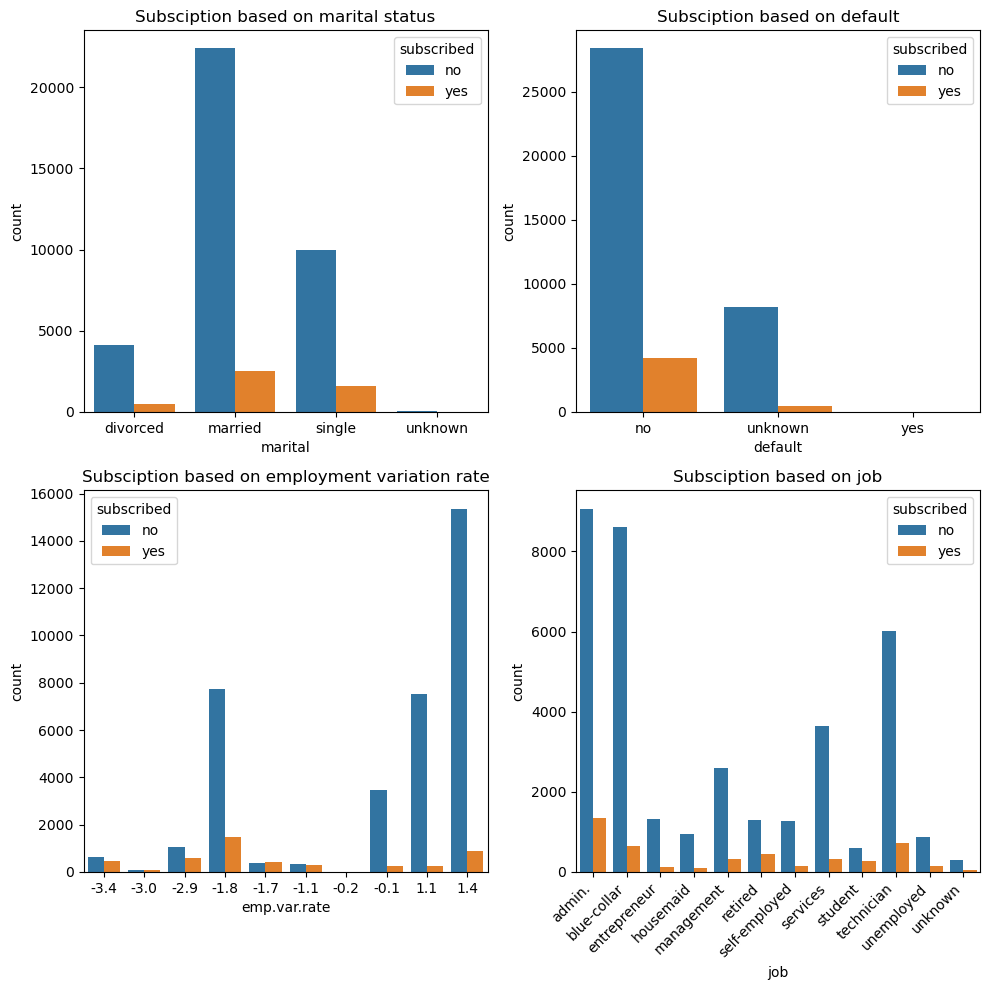

In [352]:
grouped = df_cleaned.groupby(['marital','y'])['age'].count().reset_index()
grouped = grouped.rename(columns={'age': 'count','y': 'subscribed'})

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot on the first subplot
sns.barplot(data=grouped, x="marital", y="count", hue='subscribed', ax=axes[0, 0])
axes[0,0].set_title("Subsciption based on marital status")

# Plot on the second subplot
grouped = df_cleaned.groupby(['default','y'])['age'].count().reset_index()
grouped = grouped.rename(columns={'age': 'count','y': 'subscribed'})
sns.barplot(data=grouped, x="default", y="count", hue='subscribed',ax=axes[0, 1])
axes[0,1].set_title("Subsciption based on default")


# Plot on the third subplot
grouped = df_cleaned.groupby(['emp.var.rate','y'])['age'].count().reset_index()
grouped = grouped.rename(columns={'age': 'count','y': 'subscribed'})
sns.barplot(data=grouped, x="emp.var.rate", y="count", hue='subscribed',ax=axes[1, 0])
axes[1,0].set_title("Subsciption based on employment variation rate")

# Plot on the fourth subplot
grouped = df_cleaned.groupby(['job','y'])['age'].count().reset_index()
grouped = grouped.rename(columns={'age': 'count','y': 'subscribed'})
sns.barplot(data=grouped, x="job",y='count', hue='subscribed',ax=axes[1, 1])
axes[1,1].set_title("Subsciption based on job")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Acceptance based on marital status')

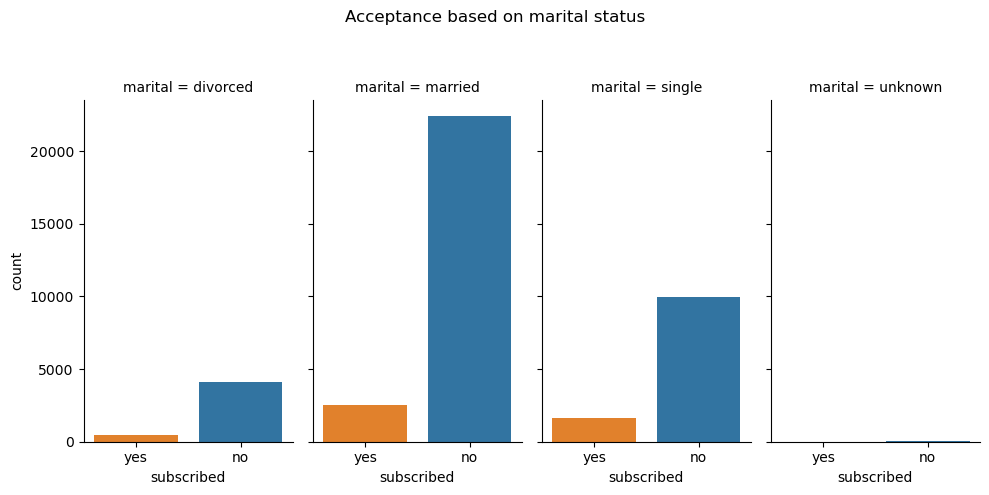

In [242]:
# Subscription count based on marital status
grouped = df_cleaned.groupby(['marital','y'])['age'].count().reset_index()
grouped = grouped.rename(columns={'age': 'count','y': 'subscribed'})

g = sns.FacetGrid(grouped, col="marital", hue="subscribed", height=5, aspect=.5)
g.map(sns.barplot, "subscribed", "count", order=['yes','no'] )
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Acceptance based on marital status')


Text(0.5, 0.98, 'Acceptance based on education')

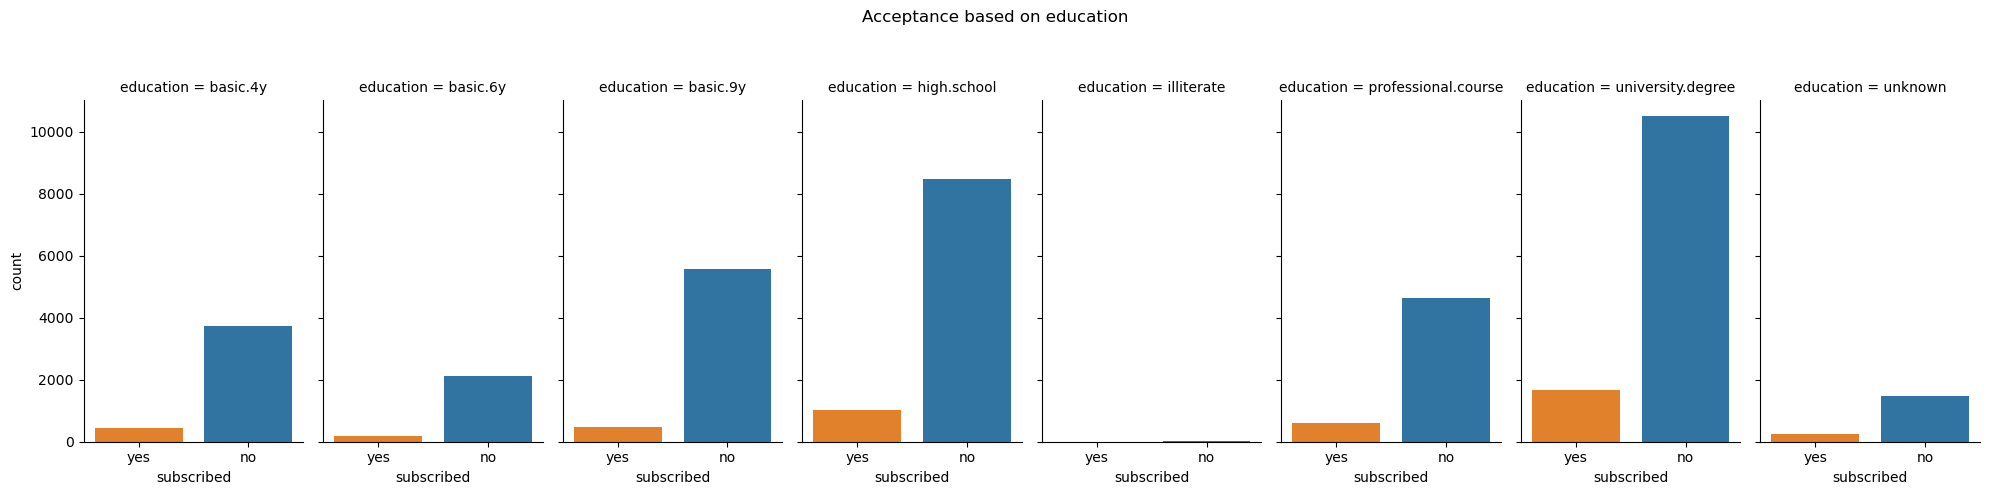

In [258]:
# Subscription count based on education
grouped = df_cleaned.groupby(['education','y'])['age'].count().reset_index()
grouped = grouped.rename(columns={'age': 'count','y': 'subscribed'})

g = sns.FacetGrid(grouped, col="education", hue="subscribed", height=5, aspect=.5)
g.map(sns.barplot, "subscribed", "count", order=['yes','no'] )
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Acceptance based on education')

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [22]:
X = df.drop('y', axis=1)
y = df['y']

In [24]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()


In [26]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [34]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
predictions = dummy_clf.predict(X_test)


In [36]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.11349842194707453


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [40]:

results = []

name   = 'logisticregression'

# Define the models and hyperparameters
model  = LogisticRegression(max_iter=1000)
params = {'logisticregression__C': [0.1, 1, 10]}

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    (name, model)
])

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)

# Fit the model and time it
start_time = time.time()
grid_search.fit(X_train, y_train)
fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])

# Get the best estimator
best_model = grid_search.best_estimator_
# Evaluate on training and test sets
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

# Append the results
results.append([name, train_score, test_score, fit_time])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time'])
results_df.set_index('model', inplace=True)

results_df

,train score,test score,average fit time
model,,,
logisticregression,0.911836,0.911143,2.020498


### Problem 9: Score the Model

What is the accuracy of your model?

In [43]:
y_pred = best_model.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(acc_score)

0.911143481427531


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [46]:
# Define the models and hyperparameters
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})
}

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    # Evaluate on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_train_acc_score = accuracy_score(y_train, y_train_pred)
    y_pred = best_model.predict(X_test)
    y_test_acc_score = accuracy_score(y_test, y_pred)
    # Append the results
    results.append([name, fit_time, train_score, y_test_acc_score])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Model'	,'Train Time',	'Train Accuracy',	'Test Accuracy'])


In [47]:
results_df.set_index('Model', inplace=True)
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
knn,2.894220,0.911836,0.904467
logisticregression,0.865630,0.911836,0.911143
svc,68.537597,0.911836,0.911143
decisiontreeclassifier,0.873472,0.911836,0.915028


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions